 # Training of the AI model with Google Colab for faster training

#### Importing face mask dataset from Google Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Unzipping images:

In [2]:
import os
from zipfile import ZipFile

path = r'/content/drive/My Drive/Data/FaceMask_Dataset'

for zip in os.listdir(path):
  file_name = os.path.join(path, zip)
  print('Unziping: ' + file_name)
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done')

Unziping: /content/drive/My Drive/Data/FaceMask_Dataset/OkFaceMask.zip
Done
Unziping: /content/drive/My Drive/Data/FaceMask_Dataset/NoFaceMask.zip
Done
Unziping: /content/drive/My Drive/Data/FaceMask_Dataset/BadFaceMask.zip
Done


#### Preparing the input data (images) and the output (prediction):

In [3]:
import pathlib
import cv2
import numpy as np

imageSize = 100
channel = 1 
path = '/content'
X = [] # Data
Y = [] # Label

dict_label  = { 'NoFaceMask':0 , 'OkFaceMask':1 , 'BadFaceMask':2 }

faceMaskDirectories = [str(directory) for directory in pathlib.Path(path).glob('*') if 'Mask' in str(directory)]

for directory in faceMaskDirectories:
  for image in pathlib.Path(directory).glob('*/*'):
    if image.suffix in {'.jpg', '.png'}:
      img = cv2.imread(str(image), 0)
      X.append(img)
      Y.append(dict_label[directory.split('/')[-1]])

X = np.asarray(X)
Y = np.asarray(Y)
print('Array X type: ' , type(X))
print('Array Y type: ' , type(Y))
print('Array X shape:' , X.shape)
print('Array Y shape:' , Y.shape)

Array X type:  <class 'numpy.ndarray'>
Array Y type:  <class 'numpy.ndarray'>
Array X shape: (14339, 100, 100)
Array Y shape: (14339,)


#### Image and label:

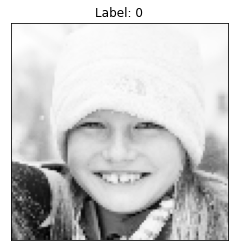

In [4]:
import matplotlib.pyplot as plt
exampleImage = 5000
plt.imshow(X[exampleImage], cmap='Greys_r')
plt.title('Label: ' + str(Y[exampleImage]))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

#### Images per label:

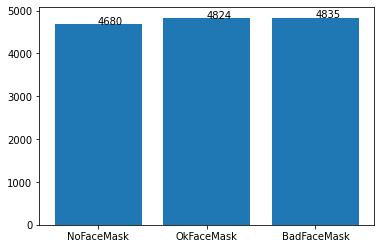

In [5]:
labels, counts = np.unique(Y, return_counts=True)
labels = np.asarray(list(dict_label.keys()))
for i in range(len(labels)):
  plt.text(x=labels[i] , y =counts[i], s=counts[i], fontdict=dict(fontsize=10))
plt.bar(labels, counts, align='center')
plt.show()

#### Splitting dataset:

In [6]:
from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# Data reshape for the model entry
X = X.reshape((X.shape[0],X.shape[1],X.shape[2],1))

# Converting vector to binary class matrix
Y = to_categorical(Y)

# Normalization
X = X/255.0

# Dataset split into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25, random_state=42)

#### Creating CNN model:

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, SpatialDropout2D, Conv2D, MaxPooling2D
import keras

keras.backend.clear_session()

model=Sequential()

model.add(Conv2D(16,(5,5), input_shape=(100, 100, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Training the model:


In [8]:
hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=64)

Epoch 1/10
169/169 [==============================] - 6s 15ms/step - loss: 0.8069 - accuracy: 0.6262 - val_loss: 0.4105 - val_accuracy: 0.8678
Epoch 2/10
169/169 [==============================] - 2s 12ms/step - loss: 0.3606 - accuracy: 0.8847 - val_loss: 0.1861 - val_accuracy: 0.9450
Epoch 3/10
169/169 [==============================] - 2s 12ms/step - loss: 0.2802 - accuracy: 0.9099 - val_loss: 0.1573 - val_accuracy: 0.9509
Epoch 4/10
169/169 [==============================] - 2s 12ms/step - loss: 0.2352 - accuracy: 0.9227 - val_loss: 0.1225 - val_accuracy: 0.9621
Epoch 5/10
169/169 [==============================] - 2s 12ms/step - loss: 0.2061 - accuracy: 0.9312 - val_loss: 0.1201 - val_accuracy: 0.9626
Epoch 6/10
169/169 [==============================] - 2s 15ms/step - loss: 0.1816 - accuracy: 0.9417 - val_loss: 0.1152 - val_accuracy: 0.9623
Epoch 7/10
169/169 [==============================] - 3s 15ms/step - loss: 0.1691 - accuracy: 0.9459 - val_loss: 0.0940 - val_accuracy: 0.9713

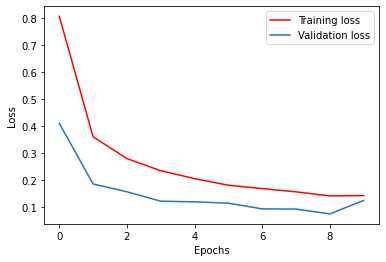

In [9]:
plt.plot(hist.history['loss'],'r',label='Training loss')
plt.plot(hist.history['val_loss'],label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

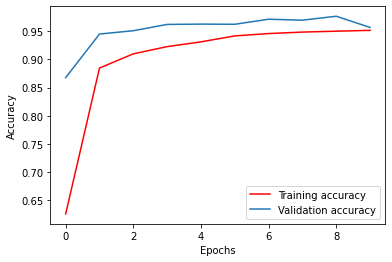

In [10]:
plt.plot(hist.history['accuracy'],'r',label='Training accuracy')
plt.plot(hist.history['val_accuracy'],label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Confusion matrix:

113/113 [==============================] - 0s 3ms/step


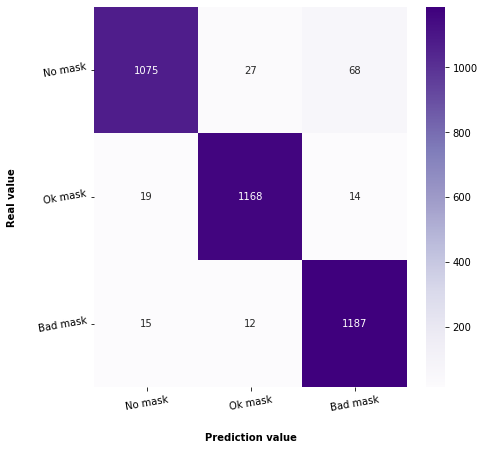

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
Y_test_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_test_true, Y_pred)

font = {
        'weight': 'bold',
        'size': 10,
        }

plt.figure(figsize=(7,7))
ax = sns.heatmap(cm, cbar=True, annot=True, fmt='g', cmap = 'Purples')
ax.set_xticklabels(['No mask', 'Ok mask', 'Bad mask'])
ax.set_yticklabels(['No mask', 'Ok mask', 'Bad mask'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
ax.set_yticklabels(ax.get_yticklabels(),rotation=10)
ax.set_xlabel(xlabel='Prediction value',labelpad=20, fontdict=font)
ax.set_ylabel(ylabel='Real value',labelpad=20, fontdict=font)
plt.show()

#### Saving the model:

In [12]:
model.save('/content/miModel.h5')